# (Global) Reshuffling CIFAR 10

Training a transformer layer to unscramble images.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from fastai.vision import *
import torch
import torchvision.transforms

## Loading CIFAR 10 dataset

In [6]:
! ls cifar10/train

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [7]:
data = ImageDataBunch.from_folder('cifar10/', size=32)

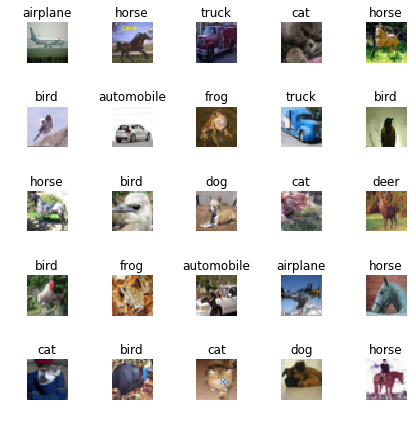

In [8]:
data.show_batch(row=3, figsize=(6,6))

### 0. (Control) Learning on Shuffled CIFAR 10

Can we learn anything on this dataset?

Test Accuracy Baseline:

####  Unshuffled
| Model | (32, 64) C(5) No Aug | (32, 128) C(5) No Aug | (8-16-24-32, 512-256-128-128) C(3) No Aug |
| ----- |--------------------- | ------------------ | -------------------------------------- |
| Resnet-18 | 68 | 70 | 64 |
| Resnet-101 | 78 | 76 | 72 |
| WRN-22 | ? | 88 | 90 | 

#### Shuffled
- No Aug = normalization
- (size, batchsize) e.g. (32, 64)
- C(N) - cycles of increasing length up to N e.g. C(5) = 1,2,3,4,5

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (torch.FloatTensor([ 0.4914 ,  0.48216,  0.44653]), torch.FloatTensor([ 0.24703,  0.24349,  0.26159]))

In [295]:
def get_data(img_size, batchsize, with_shuffle=False):
    if with_shuffle:
        tfm = GlobalShuffle(img_size, img_size).get_tfm()
        data = ImageDataBunch.from_folder('cifar10/', size=img_size, bs=batchsize, ds_tfms=([tfm], [tfm]))
    else:
        data = ImageDataBunch.from_folder('cifar10/', size=img_size, bs=batchsize)
    return data.normalize(stats)

In [296]:
def train_cycles(model, sizes, batchsizes, num, with_shuffle=False):
    if len(sizes) != len(batchsizes):
        raise ValueError("# of image sizes must match number of batchsizes")
    print(f"{num * len(sizes)} cycles will be trained. {int(len(sizes)*num*(num+1)/2)} total epochs will be run.")
    for k, (sz, bs) in enumerate(zip(sizes, batchsizes)):
        print(f"[{k}/{len(sizes)}] Size: {sz}, batchsize: {bs}")
        data = get_data(sz, bs, with_shuffle)
        learner = Learner(data, model, metrics=[accuracy])
        for cycle_len in range(num):
            learner.fit_one_cycle(cycle_len+1)
    return learner

#### Basic performance on Unshuffled

In [19]:
%timeit train_cycles(models.wrn_22(), [32], [128], 5, tfms)

5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.979107,0.908642,0.677100,01:05


epoch,train_loss,valid_loss,accuracy,time
0,0.858607,1.024689,0.648600,01:04
1,0.531405,0.539247,0.812400,01:04


epoch,train_loss,valid_loss,accuracy,time
0,0.620039,0.731728,0.748600,01:04
1,0.441738,0.549800,0.814900,01:05
2,0.237621,0.400035,0.865300,01:04


epoch,train_loss,valid_loss,accuracy,time
0,0.371041,0.860187,0.740800,01:04
1,0.339521,0.553234,0.817000,01:04
2,0.170133,0.429298,0.865300,01:04
3,0.047547,0.411529,0.877300,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.157342,0.741322,0.815600,01:03
1,0.218113,0.702741,0.804300,01:02
2,0.126020,0.549367,0.854800,01:03
3,0.033172,0.518937,0.869100,01:02
4,0.006879,0.490240,0.881300,01:02


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.986727,0.905818,0.677500,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.870232,1.211927,0.584500,01:03
1,0.546904,0.553534,0.809800,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.635508,0.815659,0.727100,01:03
1,0.456384,0.552879,0.811600,01:02
2,0.268807,0.401508,0.862400,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.398947,0.712752,0.766700,01:03
1,0.370576,0.543632,0.821200,01:03
2,0.193309,0.390750,0.874400,01:03
3,0.069322,0.387701,0.882200,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.176301,0.658896,0.819800,01:02
1,0.251042,0.544905,0.831500,01:03
2,0.160447,0.542449,0.847700,01:03
3,0.040652,0.478958,0.873700,01:03
4,0.008596,0.475190,0.882700,01:03


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.999967,0.958532,0.652000,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.882791,0.967051,0.669500,01:03
1,0.545123,0.550433,0.809300,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.645873,1.018857,0.682900,01:02
1,0.464659,0.521724,0.822600,01:03
2,0.265476,0.406057,0.859800,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.383434,0.621849,0.800200,01:02
1,0.360040,0.527726,0.830100,01:03
2,0.193178,0.420683,0.865400,01:03
3,0.067260,0.408096,0.876700,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.176047,0.682131,0.819100,01:02
1,0.247683,0.854188,0.768500,01:02
2,0.144770,0.551902,0.842200,01:03
3,0.037462,0.514736,0.872900,01:03
4,0.007500,0.501562,0.877400,01:02


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.998842,0.931562,0.665200,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.854682,0.935660,0.678200,01:03
1,0.508339,0.531144,0.820400,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.641142,0.735754,0.745600,01:02
1,0.437061,0.481862,0.835400,01:03
2,0.243233,0.389817,0.866800,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.366948,0.769464,0.759700,01:02
1,0.344586,0.552693,0.812900,01:02
2,0.178501,0.440181,0.862400,01:02
3,0.049652,0.401388,0.881000,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.160437,0.684278,0.830000,01:03
1,0.222247,0.604634,0.820700,01:02
2,0.128879,0.510522,0.854800,01:03
3,0.031941,0.524071,0.872900,01:03
4,0.005872,0.495230,0.882100,01:02


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.961046,0.909249,0.674400,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.862514,1.115040,0.618400,01:02
1,0.505745,0.534826,0.817900,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.628353,0.682985,0.764600,01:03
1,0.442338,0.518849,0.826100,01:03
2,0.240208,0.395669,0.864400,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.370476,0.623472,0.805100,01:03
1,0.347680,0.503054,0.833700,01:03
2,0.163089,0.413594,0.867600,01:03
3,0.052918,0.404268,0.880100,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.145678,0.641486,0.835700,01:02
1,0.223598,0.556955,0.829500,01:02
2,0.128074,0.501773,0.856000,01:03
3,0.036326,0.519064,0.872600,01:03
4,0.006517,0.500493,0.882000,01:03


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.982928,0.933924,0.659800,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.896480,0.904948,0.686200,01:03
1,0.548323,0.558238,0.807700,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.648221,0.687223,0.762400,01:03
1,0.467560,0.520661,0.820400,01:03
2,0.272584,0.400104,0.864500,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.384027,0.812974,0.745600,01:02
1,0.370397,0.492798,0.830100,01:03
2,0.199579,0.395095,0.871900,01:02
3,0.067593,0.387702,0.881400,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.191355,0.736716,0.806300,01:02
1,0.237758,0.587623,0.822100,01:02
2,0.147864,0.485979,0.862000,01:02
3,0.040031,0.484080,0.875000,01:03
4,0.007621,0.477313,0.883800,01:03


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.956823,0.894096,0.682300,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.848398,0.912775,0.678600,01:03
1,0.527595,0.532424,0.817900,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.616381,0.843449,0.720900,01:03
1,0.456685,0.488144,0.837400,01:02
2,0.236290,0.386752,0.872500,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.383738,0.686243,0.783000,01:03
1,0.341482,0.525842,0.826400,01:03
2,0.180575,0.419855,0.868700,01:02
3,0.062817,0.392893,0.884100,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.170385,0.707502,0.811200,01:03
1,0.238217,0.548063,0.828700,01:02
2,0.133957,0.469645,0.863700,01:02
3,0.037205,0.471007,0.882400,01:03
4,0.007210,0.480972,0.884200,01:03


5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.987322,0.920908,0.673200,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.872307,0.870385,0.695900,01:03
1,0.514984,0.545382,0.811800,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.636436,0.724912,0.752300,01:03
1,0.458845,0.502775,0.827900,01:03
2,0.250492,0.398159,0.868300,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.396150,0.537307,0.820100,01:03
1,0.346877,0.689962,0.778700,01:02
2,0.179324,0.419757,0.871000,01:03
3,0.059218,0.409822,0.882900,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.159686,0.721983,0.815700,01:02
1,0.218689,0.824590,0.785600,01:03
2,0.136179,0.533542,0.849800,01:03
3,0.034061,0.500115,0.877100,01:03
4,0.008116,0.490366,0.887300,01:02


15min 47s ± 941 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
wrn22_pyramid_cycle = train_cycles(models.wrn_22(), [8, 16, 24, 32], [512, 256, 128, 128], 3, tfms)

12 cycles will be trained. 24 total epochs will be run.
[0/4] Size: 8, batchsize: 512


epoch,train_loss,valid_loss,accuracy,time
0,1.472276,1.310438,0.519700,00:20


epoch,train_loss,valid_loss,accuracy,time
0,1.296293,1.312893,0.533300,00:20
1,1.053633,1.101400,0.612400,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.992346,1.272366,0.567900,00:20
1,0.907214,1.149615,0.604600,00:20
2,0.547035,1.181339,0.625500,00:20


[1/4] Size: 16, batchsize: 256


epoch,train_loss,valid_loss,accuracy,time
0,0.840736,0.762959,0.732000,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.770612,0.857489,0.697900,00:22
1,0.455639,0.624213,0.786200,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.534624,0.984176,0.685700,00:22
1,0.400411,0.714280,0.772300,00:22
2,0.110469,0.733763,0.788700,00:22


[2/4] Size: 24, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.425682,0.428796,0.853100,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.480573,0.660466,0.780500,00:45
1,0.221271,0.383936,0.874300,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.343469,0.625542,0.803400,00:45
1,0.215427,0.458138,0.853900,00:45
2,0.039533,0.436954,0.875700,00:45


[3/4] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,0.212847,0.306857,0.895600,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.274138,0.405236,0.864400,01:02
1,0.079058,0.290402,0.906600,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.202152,0.431370,0.863500,01:01
1,0.111930,0.347726,0.894200,01:01
2,0.015291,0.322782,0.908300,01:01


### Shuffle on the CIFAR 10 Dataset

In [294]:
class GlobalShuffle:
    def __init__(self, numRows, numCols):
        self.numRows = numRows
        self.numCols = numCols
        self.permuteVector = np.random.permutation(numRows * numCols)
        self.unpermuteVector = np.empty(numRows * numCols, self.permuteVector.dtype)
        self.unpermuteVector[self.permuteVector] = np.arange(numRows * numCols)
        
    def permuteArr(self, imgArr):
        """Permutes RGB rank 3 image"""
        return self._permuteArr(imgArr, self.permuteVector)
    
    def unPermuteArr(self, imgArr):
        """Unpermutes RGB rank 3 image"""
        return self._permuteArr(imgArr, self.unpermuteVector)
    
    def permuteTensor(self, imgTensor):
        """Permutes RGB rank 3 image torch tensor
        Assumes dimensions: [channel, height, width]
        Does not permute channel"""
        imgDim = list(imgTensor.shape)
        if len(imgDim) != 3:
            raise ValueError(f"Expected to have tensor with 3 dimensions, got {len(imgDim)} dimensions instead.")
        transposedImgTensor = imgTensor.unsqueeze(0).transpose(0,3).transpose(1,2)
        permutedImgTensor = torch.Tensor(self.permuteArr(transposedImgTensor.data.numpy()))
        permutedImgTensor = permutedImgTensor.unsqueeze(0).transpose(1,2).transpose(0,3).squeeze()
        return permutedImgTensor
    
    def unPermuteTensor(self, imgTensor):
        """Unpermutes RGB rank 3 image torch tensor
        Assumes dimensions: [channel, height, width]
        Does not permute channel"""
        imgDim = list(imgTensor.shape)
        if len(imgDim) != 3:
            raise ValueError(f"Expected to have tensor with 3 dimensions, got {len(imgDim)} dimensions instead.")
        transposedImgTensor = imgTensor.unsqueeze(0).transpose(0,3).transpose(1,2)
        permutedImgTensor = torch.Tensor(self.unPermuteArr(transposedImgTensor.data.numpy()))
        permutedImgTensor = permutedImgTensor.unsqueeze(0).transpose(1,2).transpose(0,3).squeeze()
        return permutedImgTensor
    
    def _permuteArr(self, imgArr, permuteVector):
        """Internal method to simplify permutation"""
        flatImgArr = np.reshape(imgArr, (self.numRows * self.numCols, -1))
        flatPermutedArr = flatImgArr[permuteVector]
        return flatPermutedArr.reshape((self.numRows, self.numCols, -1))
    
    def get_tfm(self):
        shuffle_tfm = TfmPixel(lambda x: self.permuteTensor(x), order=1)
        return RandTransform(shuffle_tfm, {}, is_random=False)

In [265]:
shuffle = GlobalShuffle(3, 3)
sampleArr = torch.Tensor(np.arange(27).reshape((3,3,3)))
shuffledSampleArr = shuffle.permuteTensor(sampleArr)
unshuffledSampleArr = shuffle.unPermuteTensor(shuffledSampleArr)
print(sampleArr, sampleArr.shape)
print(shuffledSampleArr, shuffledSampleArr.shape)
print(unshuffledSampleArr, unshuffledSampleArr.shape)

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.]],

        [[ 9., 10., 11.],
         [12., 13., 14.],
         [15., 16., 17.]],

        [[18., 19., 20.],
         [21., 22., 23.],
         [24., 25., 26.]]]) torch.Size([3, 3, 3])
tensor([[[ 1.,  8.,  3.],
         [ 2.,  5.,  6.],
         [ 4.,  7.,  0.]],

        [[10., 17., 12.],
         [11., 14., 15.],
         [13., 16.,  9.]],

        [[19., 26., 21.],
         [20., 23., 24.],
         [22., 25., 18.]]]) torch.Size([3, 3, 3])
tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.]],

        [[ 9., 10., 11.],
         [12., 13., 14.],
         [15., 16., 17.]],

        [[18., 19., 20.],
         [21., 22., 23.],
         [24., 25., 26.]]]) torch.Size([3, 3, 3])


In [287]:
cifarShuffle = GlobalShuffle(32, 32)

(32, 32, 3)
torch.Size([3, 32, 32])


Text(0.5,1,'Unshuffled: frog')

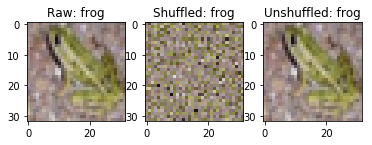

In [288]:
img, label = data.train_ds[0]
np_img = img.data.numpy().transpose((1, 2, 0))
print(np_img.shape)
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(np_img)
ax[0].set_title(f"Raw: {label}")

shuffled_img = cifarShuffle.permuteTensor(img.data)
print(shuffled_img.shape)
ax[1].imshow(shuffled_img.numpy().transpose((1,2,0)))
ax[1].set_title(f"Shuffled: {label}")

unshuffled_img = cifarShuffle.unPermuteTensor(shuffled_img)
ax[2].imshow(unshuffled_img.numpy().transpose((1,2,0)))
ax[2].set_title(f"Unshuffled: {label}")

In [289]:
shuffle_tfm = TfmPixel(lambda x: cifarShuffle.permuteTensor(x), order=1)

In [290]:
shuffle_rand_trans = RandTransform(shuffle_tfm, {}, is_random=False)

In [291]:
test_shuffled = ImageDataBunch.from_folder('cifar10/', ds_tfms=([shuffle_rand_trans], [shuffle_rand_trans])).normalize(stats)

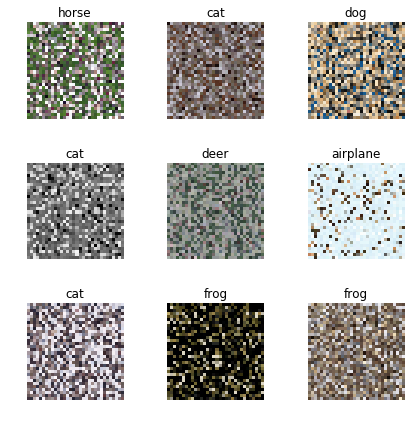

In [292]:
test_shuffled.show_batch(3, DatasetType.Train, figsize=(6,6))

### Performance on Shuffled CIFAR-10

| Model | (32, 256) 30 Epochs |(32, 128) C(5) No Aug | (8-16-24-32,512-256-128-128) C(3) No Aug |
| ----- | ------------------- |--------------------- | ---------------------------------------- |
| wrn22 |         50          |         53*          |                 57**                     |


\* Model stagnated around 53% accuracy, so it's likely that there wasn't anything being learned.

\** Mofd

In [297]:
train_cycles(models.wrn_22(), [32], [128], 5, with_shuffle=True)

5 cycles will be trained. 15 total epochs will be run.
[0/1] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,1.533642,1.471352,0.466600,01:01


epoch,train_loss,valid_loss,accuracy,time
0,1.495461,1.504444,0.458200,01:01
1,1.208571,1.298502,0.534400,01:01


epoch,train_loss,valid_loss,accuracy,time
0,1.292362,1.432865,0.492600,01:01
1,1.104607,1.332221,0.535600,01:01
2,0.624719,1.433945,0.542400,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.768311,1.713268,0.482200,01:02
1,0.839032,1.538488,0.513100,01:01
2,0.408268,1.787493,0.523900,01:02
3,0.098657,1.984309,0.534600,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.307915,2.273157,0.503300,01:00
1,0.559414,1.912297,0.501800,01:00
2,0.333336,2.073142,0.518500,01:00
3,0.086218,2.428468,0.533200,01:00
4,0.015204,2.492942,0.534200,01:00


Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
frog,frog,frog,frog,frog
Path: cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
frog,frog,frog,frog,frog
Path: cifar10;

Test: None, model=WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [298]:
train_cycles(models.wrn_22(), (8,16,24,32), (512, 256, 128, 128), 3, with_shuffle=True)

12 cycles will be trained. 24 total epochs will be run.
[0/4] Size: 8, batchsize: 512


epoch,train_loss,valid_loss,accuracy,time
0,1.565126,1.428300,0.492700,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.406272,1.410675,0.503100,00:22
1,1.173403,1.266621,0.553500,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.106045,1.388728,0.522300,00:22
1,1.028903,1.347608,0.530700,00:22
2,0.609115,1.428502,0.560300,00:22


[1/4] Size: 16, batchsize: 256


epoch,train_loss,valid_loss,accuracy,time
0,1.373437,1.296375,0.534900,00:24


epoch,train_loss,valid_loss,accuracy,time
0,1.275080,1.382119,0.506100,00:24
1,0.874437,1.232481,0.577300,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.905766,1.403613,0.529000,00:24
1,0.747972,1.382898,0.557700,00:24
2,0.186988,1.641303,0.570000,00:24


[2/4] Size: 24, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,1.267281,1.240189,0.552200,00:46


epoch,train_loss,valid_loss,accuracy,time
0,1.233889,1.386727,0.512000,00:45
1,0.749949,1.223980,0.582200,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.877494,1.408559,0.538800,00:45
1,0.662471,1.408078,0.559900,00:46
2,0.109455,1.710923,0.573700,00:46


[3/4] Size: 32, batchsize: 128


epoch,train_loss,valid_loss,accuracy,time
0,1.265697,1.250002,0.554600,01:01


epoch,train_loss,valid_loss,accuracy,time
0,1.196071,1.302474,0.534900,01:00
1,0.588910,1.321597,0.569400,01:00


epoch,train_loss,valid_loss,accuracy,time
0,0.716552,1.662432,0.498600,01:00
1,0.508761,1.576487,0.551300,01:00
2,0.054665,1.814805,0.564000,01:00


Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
frog,frog,frog,frog,frog
Path: cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
frog,frog,frog,frog,frog
Path: cifar10;

Test: None, model=WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [301]:
tmpLearner = Learner(get_data(32, 256, with_shuffle=True), models.wrn_22(), metrics=[accuracy])
tmpLearner.fit(30)

epoch,train_loss,valid_loss,accuracy,time
0,1.759820,1.713019,0.362300,00:59
1,1.545369,1.521003,0.445300,01:00
2,1.401065,1.488052,0.462600,01:00
3,1.254668,1.397265,0.497600,00:59
4,1.095772,1.470509,0.490000,00:59
5,0.908243,1.479437,0.514200,00:59
6,0.727534,1.604956,0.512000,00:59
7,0.585249,1.942595,0.486100,00:59
8,0.461336,2.073636,0.492200,00:59
9,0.380110,2.145911,0.499000,00:59
